<a href="https://colab.research.google.com/github/melogabriel/geo_analysis/blob/main/Geo_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instructions:
1. Insert your CSV file path or use Colab's file uploader. Dataset example [here](/content/geoexperiment_dataset.csv).
2. The notebook runs t-tests comparing Cities.
3. The result of the t-test shows an insight for each city.
3. ROAS is calculated and visualized for decision-making.
4. Easily switch datasets by re-uploading and rerunning the cells.

This section of the code sets up the environment for data analysis by importing necessary libraries.

In [35]:
# Geo Experiment Analysis Notebook

# ✅ Import Libraries
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

This section of the code is specifically designed for use within Google Colab, an online environment for running Python code. It allows the user to easily upload a CSV file and load it into a pandas DataFrame for analysis.

In [36]:
# ✅ Colab File Uploader
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

Saving geoexperiment_dataset.csv to geoexperiment_dataset (2).csv


This step is done to avoid division by zero errors when calculating metrics like Return on Ad Spend (ROAS), which involves dividing response or revenue by cost. It ensures that only cities with non-zero advertising costs are included in the analysis.

In [37]:
# ✅ Data Cleaning
df['response'] = df['response'].str.replace(',', '').astype(float)
df = df[df['cost'] != 0]  # Exclude cities where cost is 0

This part of the code is designed to calculate and display summary statistics for each city in your dataset. It essentially groups the data by city and then computes various metrics for each group.

In [38]:
# ✅ Data Summary
city_summary = df.groupby('city').agg(
    total_cost=('cost', 'sum'),
    total_response=('response', 'sum'),
    avg_cost=('cost', 'mean'),
    avg_response=('response', 'mean'),
    count=('response', 'count')
).reset_index()

print("\nCity Summary:")
print(city_summary)



City Summary:
        city  total_cost  total_response    avg_cost  avg_response  count
0     Aveiro      317.21           159.0   11.328929      5.678571     28
1       Beja        6.12             0.0    3.060000      0.000000      2
2      Braga      472.30           124.0   15.235484      4.000000     31
3   Braganca        1.02             0.0    0.510000      0.000000      2
4    Coimbra       28.80           104.0    1.800000      6.500000     16
5       Faro       13.28           104.0    2.213333     17.333333      6
6     Guarda        0.54            89.0    0.540000     89.000000      1
7     Leiria      117.19           303.0    4.882917     12.625000     24
8     Lisbon     4722.34          5318.0  152.333548    171.548387     31
9      Porto     2284.64          3320.4   73.698065    107.109677     31
10     Viseu       70.41             0.0    4.141765      0.000000     17


In simpler terms, this code analyzes how changes in advertising spending (cost) affect the response in each city. It helps determine if the relationship is statistically significant and how well the model fits the data. The results are then organized and displayed for easy interpretation.

In [39]:
# Group data by city and run a regression (response ~ cost) for each city
results = {}
for city, city_data in df.groupby("city"):
    X = city_data["cost"]
    y = city_data["response"]

    # Add a constant term for the intercept in regression
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Store the results (p-value and R-squared)
    results[city] = {
        "p_value": model.pvalues["cost"],
        "r_squared": model.rsquared
    }

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results, orient="index").reset_index()
results_df.columns = ["city", "p_value", "r_squared"]
results_df.sort_values(by="p_value", inplace=True)  # Sort by significance

# Display the top 10 results
print(results_df.head(10))

       city   p_value  r_squared
8    Lisbon  0.036044   0.142859
0    Aveiro  0.311298   0.039395
4   Coimbra  0.357915   0.060636
7    Leiria  0.463886   0.024637
9     Porto  0.471756   0.018003
5      Faro  0.522073   0.109343
2     Braga  0.963801   0.000072
1      Beja       NaN        NaN
3  Braganca       NaN        NaN
6    Guarda       NaN        NaN


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


**How the Interpretation Works:**

**p_value < 0.05**: This indicates that the relationship between ad spend (cost) and response is statistically significant. In simpler terms, it's unlikely that the observed relationship is due to random chance.

r**_squared >= 0.5**: This suggests a moderate to strong relationship between ad spend and response. A higher r_squared means the model explains a larger proportion of the variance in the response variable.

**Interpretations:**

**Significant and strong:** If both conditions (low p_value and high r_squared) are true, it means ad spend has a clear and positive impact on response in that city.

**Significant but weak:** If the p_value is low but r_squared is below 0.5, it indicates a statistically significant relationship, but ad spend might not be the primary driver of response. Other factors might be influencing the results.

**Not significant:** If the p_value is above 0.05, it suggests that ad spend does not have a statistically significant impact on response in that city.
By adding this interpretation column, the results become more informative and actionable. You can now easily identify cities where ad spend is most effective and make data-driven decisions for your campaigns.

In [41]:
# Add interpretation based on p-value and r-squared
results_df['interpretation'] = ''  # Add a new column for interpretation
for index, row in results_df.iterrows():
    p_value = row['p_value']
    r_squared = row['r_squared']
    city = row['city']

    if p_value < 0.05:  # Check for statistical significance
        if r_squared >= 0.5:  # Check for moderate to strong relationship
            interpretation = f"In {city}, ad spend has a statistically significant and strong positive impact on response (p={p_value:.3f}, R²={r_squared:.3f})."
        else:
            interpretation = f"In {city}, ad spend has a statistically significant but weak impact on response (p={p_value:.3f}, R²={r_squared:.3f}). Consider other factors."
    else:
        interpretation = f"In {city}, ad spend does not have a statistically significant impact on response (p={p_value:.3f}, R²={r_squared:.3f})."

    results_df.loc[index, 'interpretation'] = interpretation  # Update the DataFrame

# Display the results with interpretation
for _, row in results_df.iterrows():
    print(row['interpretation'])


In Lisbon, ad spend has a statistically significant but weak impact on response (p=0.036, R²=0.143). Consider other factors.
In Aveiro, ad spend does not have a statistically significant impact on response (p=0.311, R²=0.039).
In Coimbra, ad spend does not have a statistically significant impact on response (p=0.358, R²=0.061).
In Leiria, ad spend does not have a statistically significant impact on response (p=0.464, R²=0.025).
In Porto, ad spend does not have a statistically significant impact on response (p=0.472, R²=0.018).
In Faro, ad spend does not have a statistically significant impact on response (p=0.522, R²=0.109).
In Braga, ad spend does not have a statistically significant impact on response (p=0.964, R²=0.000).
In Beja, ad spend does not have a statistically significant impact on response (p=nan, R²=nan).
In Braganca, ad spend does not have a statistically significant impact on response (p=nan, R²=nan).
In Guarda, ad spend does not have a statistically significant impact o

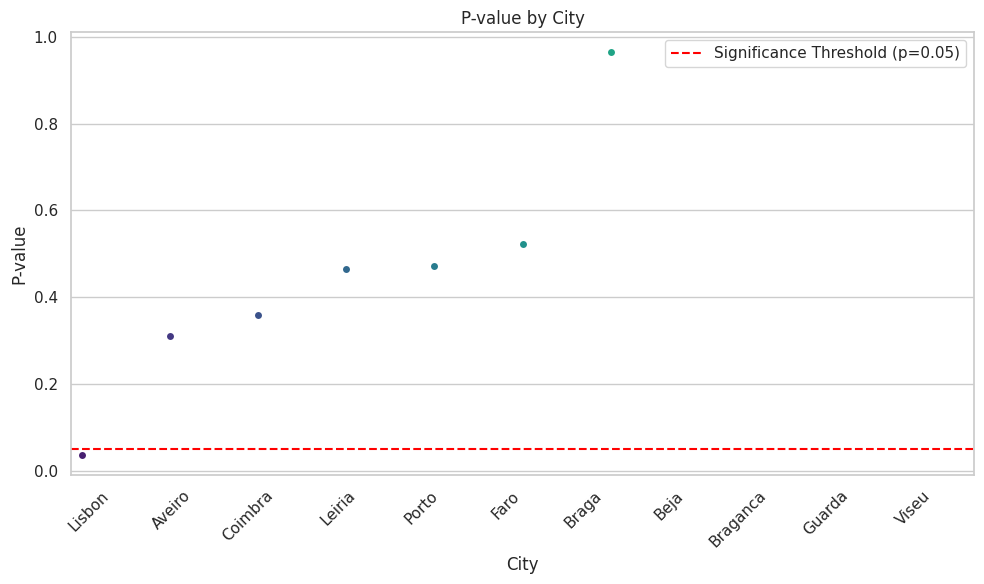

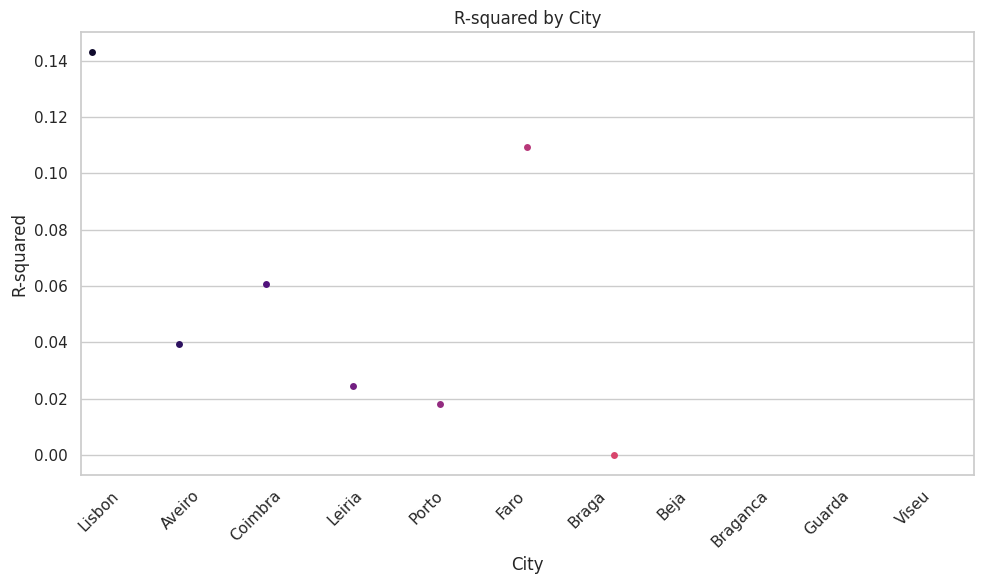

In [50]:
# Assuming 'results_df' is your DataFrame with city, p_value, and r_squared

# --- Visualization for p-value ---
plt.figure(figsize=(10, 6))
sns.stripplot(data=results_df, x='city', y='p_value', hue='city', palette='viridis',
              jitter=True, dodge=True, legend=False)  # Assign x to hue and set legend=False
plt.title('P-value by City')
plt.xlabel('City')
plt.ylabel('P-value')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0.05, linestyle='--', color='red', label='Significance Threshold (p=0.05)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Visualization for r-squared ---
plt.figure(figsize=(10, 6))
sns.stripplot(data=results_df, x='city', y='r_squared', hue='city', palette='magma',
              jitter=True, dodge=True, legend=False)  # Assign x to hue and set legend=False
plt.title('R-squared by City')
plt.xlabel('City')
plt.ylabel('R-squared')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This section takes the results of the t-tests that were calculated earlier and organizes them into a neat table (DataFrame) and then prints that table to the console for you to see. This makes it much easier to interpret the results compared to having them in a less organized format.

In [42]:
# ✅ ROAS Calculation
city_summary['ROAS'] = city_summary['total_response'] / city_summary['total_cost']

print("\nROAS by City:")
print(city_summary[['city', 'ROAS']])


ROAS by City:
        city        ROAS
0     Aveiro    0.501245
1       Beja    0.000000
2      Braga    0.262545
3   Braganca    0.000000
4    Coimbra    3.611111
5       Faro    7.831325
6     Guarda  164.814815
7     Leiria    2.585545
8     Lisbon    1.126137
9      Porto    1.453358
10     Viseu    0.000000


<ipython-input-43-2564ea4de9ad>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=city_summary, x='city', y='ROAS', palette='viridis')


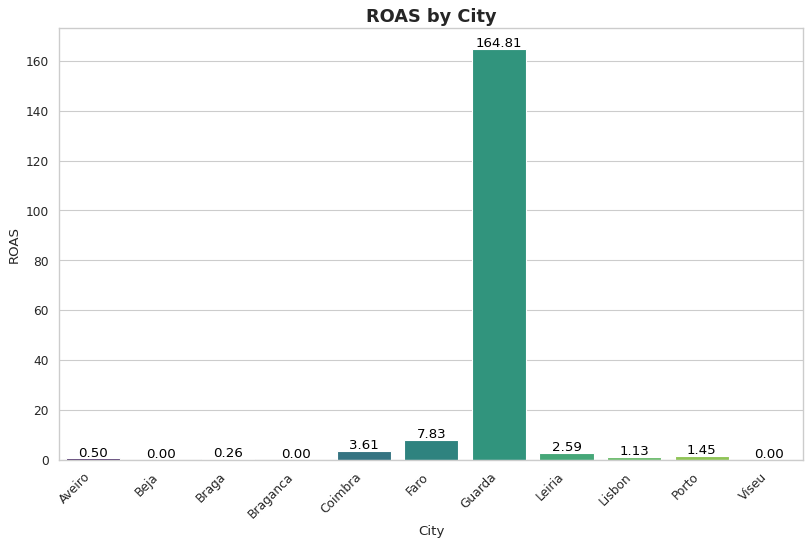

In [43]:
# ✅ Visualization
# Set the style to "whitegrid" for a clean background
sns.set(style="whitegrid")

# Create a figure with transparent background
plt.figure(figsize=(12, 7), dpi=80)

# Create the barplot with 'viridis' color palette
ax = sns.barplot(data=city_summary, x='city', y='ROAS', palette='viridis')

# Add title and labels with more styling for better presentation
plt.title('ROAS by City', fontsize=16, weight='bold')
plt.xlabel('City', fontsize=12)
plt.ylabel('ROAS', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add data labels above each bar for clarity
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

# Set the background of the figure and axes to transparent
plt.gcf().patch.set_alpha(0.0)
ax.set_facecolor('none')

# Show the plot
plt.show()